**PROBLEM STATEMENT**

Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks.

 As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.



With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores.


Since the company is just embarking on this project, the scope has been kept to nine key stores across Europe. The stores are key for the company keeping in mind the revenue and historical prestige associated with them. These stores are numbered - 1,3,8,9,13,25,29,31 and 46.

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX # Import the VARMAX class
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
warnings.filterwarnings('ignore')

Importing and inspecting both the Train data and the Stores data

In [106]:
data = pd .read_csv('train.csv')
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [107]:
store_data = pd.read_csv('store.csv')
data.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [108]:
store_data.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


Checking for missing values

In [109]:
store_data.isnull().sum()

,0
Store,0
StoreType,0
Assortment,0
CompetitionDistance,3
CompetitionOpenSinceMonth,354
CompetitionOpenSinceYear,354
Promo2,0
Promo2SinceWeek,544
Promo2SinceYear,544
PromoInterval,544


handling the missing values by substituing with mean for Competition distance

In [110]:
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].mean(), inplace = True)

In [111]:
store_data.fillna(0, inplace = True)

In [112]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [113]:
store_data.isnull().sum()

,0
Store,0
StoreType,0
Assortment,0
CompetitionDistance,0
CompetitionOpenSinceMonth,0
CompetitionOpenSinceYear,0
Promo2,0
Promo2SinceWeek,0
Promo2SinceYear,0
PromoInterval,0


In [114]:
merged_data = pd.merge(data, store_data, on='Store', how='left')
merged_data.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


Since the company is just embarking on this project, the scope has been kept to nine key stores across Europe. The stores are key for the company keeping in mind the revenue and historical prestige associated with them. These stores are numbered - 1,3,8,9,13,25,29,31 and 46.
Hence lets filter out only these 9 store's data .


In [115]:
Key_stores_data = merged_data[
        (merged_data.Store == 1) | (merged_data.Store == 3)| (merged_data.Store == 8)| (merged_data.Store == 9)| (merged_data.Store == 13) |
        (merged_data.Store == 25) | (merged_data.Store == 29)| (merged_data.Store == 31)| (merged_data.Store == 46)
     ]

In [116]:
Key_stores_data.shape

(8110, 18)

In [117]:
Key_stores_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,0.0,0.0,0
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,0.0,0.0,0
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,0.0,0.0,1,45.0,2009.0,"Feb,May,Aug,Nov"


Finding outliers and handling the same

In [118]:
# Calculate the 99th percentile of the 'Sales' column
percentile_99 = np.percentile(Key_stores_data['Sales'], 99)

# Identify outliers (values above the 99th percentile)
outliers = Key_stores_data[Key_stores_data['Sales'] > percentile_99]

# Remove outliers from the DataFrame
data_no_outliers = Key_stores_data[Key_stores_data['Sales'] <= percentile_99]

# Print the number of outliers removed
print(f"Number of outliers removed: {len(outliers)}")



Number of outliers removed: 82


In [119]:
# Calculate z-scores for 'Sales' and 'Customers'
data_no_outliers['Sales_zscore'] = zscore(data_no_outliers['Sales'])
data_no_outliers['Customers_zscore'] = zscore(data_no_outliers['Customers'])

# Print the updated DataFrame with standardized variables
print(data_no_outliers[['Sales', 'Sales_zscore', 'Customers', 'Customers_zscore']].head())


    Sales  Sales_zscore  Customers  Customers_zscore
0    5263     -0.004811        555         -0.052077
2    8314      0.927761        821          0.619617
7    8492      0.982169        833          0.649918
8    8565      1.004482        687          0.281245
12   8821      1.082731        568         -0.019250


By looking at the dataset we can see that teh columns "sales" are "customers" are the two time series data .
We shall do a stationairty test on both of them and also a test to determine if they are correlated

In [120]:
#ADF test to determine stationarity
ad_fuller_test_result_1 = adfuller(data_no_outliers['Sales'])
print('ADF Statistic: %f' % ad_fuller_test_result_1[0])
print('p-value: %f' % ad_fuller_test_result_1[1])


print("_________________________________________")


ad_fuller_test_result_2 = adfuller(data_no_outliers['Customers'])
print('ADF Statistic: %f' % ad_fuller_test_result_2[0])
print('p-value: %f' % ad_fuller_test_result_2[1])


ADF Statistic: -17.306309
p-value: 0.000000
_________________________________________
ADF Statistic: -18.510508
p-value: 0.000000


Observation : P values for both Sales and Customers Time series is less than 0.05 hence the series are stationary.

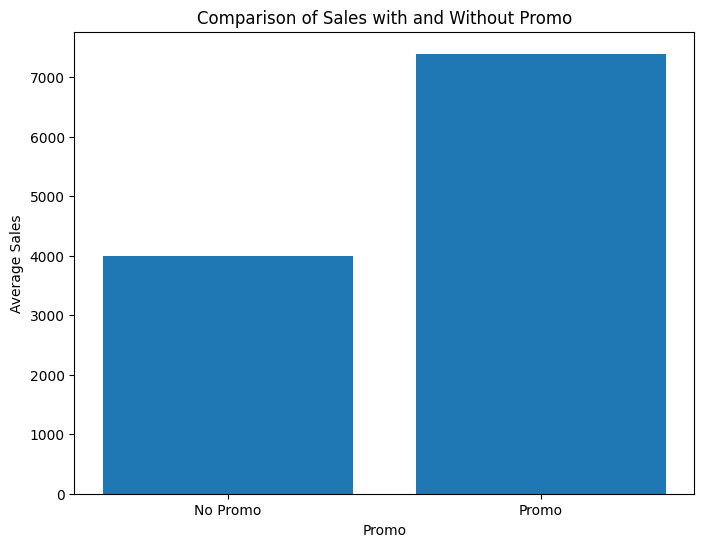

In [121]:
# Group data by 'Promo' and calculate the mean sales for each group
promo_sales = data_no_outliers.groupby('Promo')['Sales'].mean()

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(promo_sales.index, promo_sales.values)
plt.xlabel('Promo')
plt.ylabel('Average Sales')
plt.title('Comparison of Sales with and Without Promo')
plt.xticks([0, 1], ['No Promo', 'Promo'])
plt.show()


Observation. : It is very clear from the above plot that Promo influences sales directly .


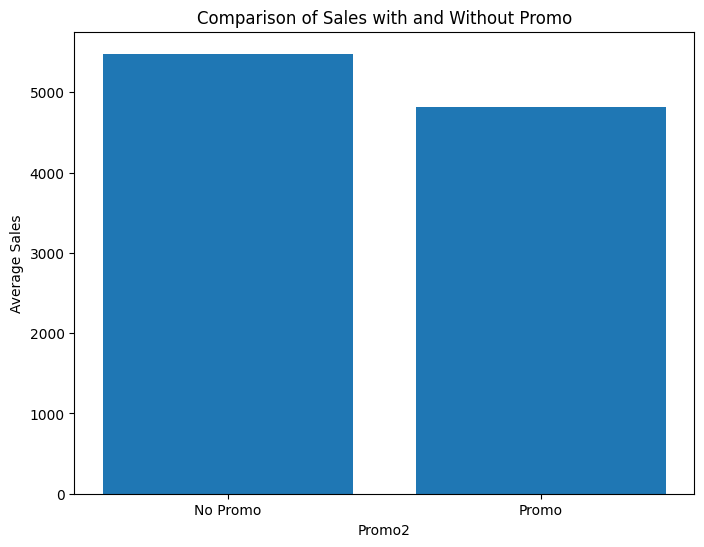

In [122]:
promo_sales = data_no_outliers.groupby('Promo2')['Sales'].mean()

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(promo_sales.index, promo_sales.values)
plt.xlabel('Promo2')
plt.ylabel('Average Sales')
plt.title('Comparison of Sales with and Without Promo')
plt.xticks([0, 1], ['No Promo', 'Promo'])
plt.show()

There is no effect of promo2 on sales

In [123]:

# Drop columns related to Store Types
columns_to_drop = ['StoreType', 'Assortment', 'CompetitionOpenSinceMonth',
                  'CompetitionOpenSinceYear', 'Promo2SinceWeek',
                  'Promo2SinceYear', 'PromoInterval','CompetitionDistance','Promo2']

data_no_outliers = data_no_outliers.drop(columns=columns_to_drop, errors='ignore')

# Now 'data_no_outliers' will have the specified columns removed.


In [124]:
data_no_outliers.shape

(8028, 11)

In [125]:
data_no_outliers.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales_zscore,Customers_zscore
0,1,5,2015-07-31,5263,555,1,1,0,1,-0.004811,-0.052077
2,3,5,2015-07-31,8314,821,1,1,0,1,0.927761,0.619617
7,8,5,2015-07-31,8492,833,1,1,0,1,0.982169,0.649918
8,9,5,2015-07-31,8565,687,1,1,0,1,1.004482,0.281245
12,13,5,2015-07-31,8821,568,1,1,0,0,1.082731,-0.019250


In [127]:
sales_customers_data = data_no_outliers[['Sales', 'Customers']]

# Perform the Johansen test
joh_model1 = coint_johansen(sales_customers_data,-1,1)

def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1], index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [128]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
joh_model1 = coint_johansen(data[['Sales', 'Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

    max_eig_stat     trace_stat
0  344850.657673  369745.721205
1   24895.063532   24895.063532 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [129]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
rank=select_coint_rank(data[['Sales', 'Customers']],-1,1)
print(rank.rank)

2


In [130]:
#we can build a VAR or VARMAX model since the rank is 2

In [131]:
len(data_no_outliers)

8028

In [132]:
# By inspecting the dataframe it is clear that a single day's sales data accross all 9 stores is in 9 rows .
# We need to set aside 6 weeks data for testing , which is 6*7 = 42 days
# 42 days data for all nine stores is 42*9 = 378 rows

test_len = 378
train_len = len(data_no_outliers) - test_len
print(train_len)

7650


In [133]:
# Splitthing the data for train and test
train = data_no_outliers.iloc[0:train_len, :]
test = data_no_outliers.iloc[train_len:,:]
print(train.shape)
print(test.shape )

(7650, 11)
(378, 11)


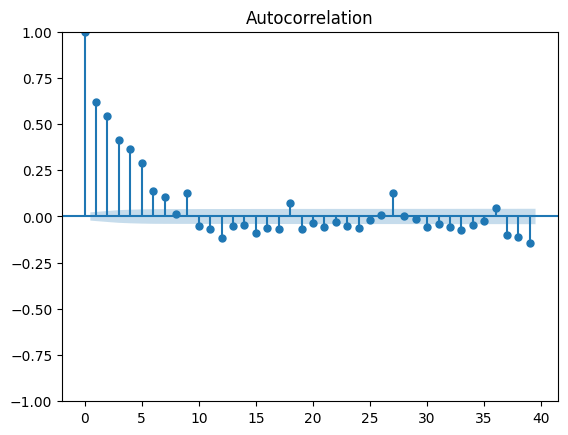

In [134]:
# Plotting ACF plot to determine the lag value

plot_acf(train['Sales'])
plt.show()


In [135]:
var_model = VARMAX(train[['Sales_zscore','Customers_zscore']],order=(2,0))
res = var_model.fit(maxiter=1000, disp=False)
print(res.summary())

                                    Statespace Model Results                                    
Dep. Variable:     ['Sales_zscore', 'Customers_zscore']   No. Observations:                 7650
Model:                                           VAR(2)   Log Likelihood              -11267.154
                                            + intercept   AIC                          22560.307
Date:                                  Tue, 25 Mar 2025   BIC                          22650.559
Time:                                          14:27:11   HQIC                         22591.268
Sample:                                               0                                         
                                                 - 7650                                         
Covariance Type:                                    opg                                         
Ljung-Box (L1) (Q):             5.13, 0.00   Jarque-Bera (JB):      1147.83, 429.43
Prob(Q):                        0.02, 0.95 

In [136]:
predictions = res.forecast(steps=test_len, exog =test['Promo'])
predictions['Date'] = test.index
predictions = predictions.set_index('Date')

sales_mean = train['Sales'].mean()
sales_std = train['Sales'].std()
predictions['Sales'] = (predictions['Sales_zscore'] * sales_std) + sales_mean

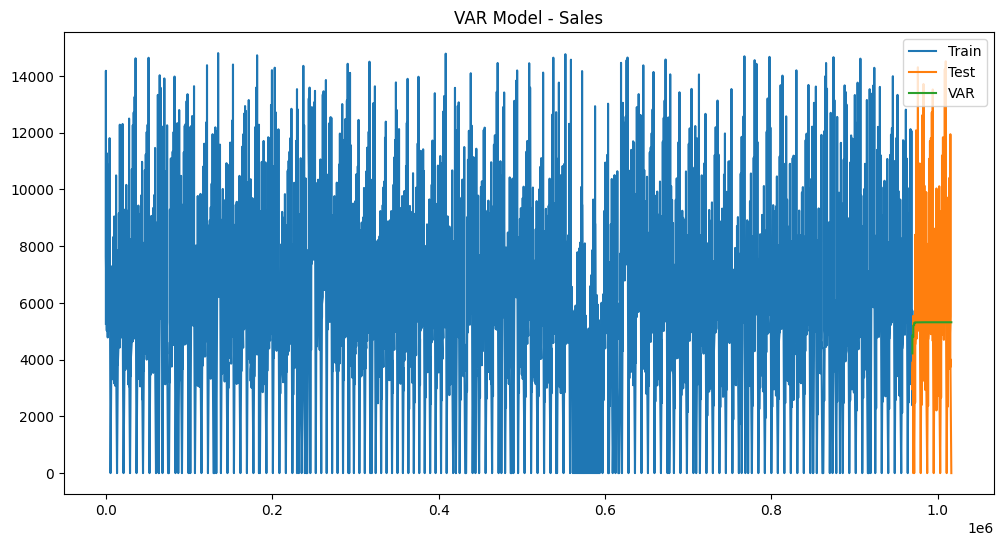

In [137]:
plt.figure(figsize=(12,6))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Sales')
plt.show()

In [139]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales, predictions.Sales)).round(2)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VAR'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'RMSE']=rmse

# Mean Absolute Percentage Error
abs_error = np.abs(test.Sales-predictions.Sales)
actual = test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)

model_comparison.loc[model_comparison['Variable']=='Sales', 'MAPE'] = mape

# Initialize results_display as an empty DataFrame if it doesn't exist
results_display = pd.DataFrame()
results_display = pd.concat([results_display, model_comparison])
results_display

,Model,Variable,RMSE,MAPE
0,VAR,Sales,3052.37,inf


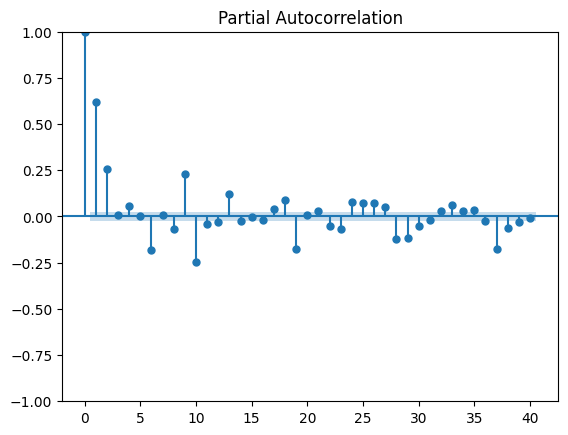

In [150]:
# plotting PACF to determine moving average parameter q

plot_pacf(train['Sales'], lags=40)
plt.show()


In [141]:
var_model = VARMAX(train[['Sales_zscore','Customers_zscore']],order=(2,2), exog=train['Promo'])
res = var_model.fit(maxiter=1000, disp=False)
print(res.summary())

                                    Statespace Model Results                                    
Dep. Variable:     ['Sales_zscore', 'Customers_zscore']   No. Observations:                 7650
Model:                                      VARMAX(2,2)   Log Likelihood              -10100.732
                                            + intercept   AIC                          20247.464
Date:                                  Tue, 25 Mar 2025   BIC                          20407.141
Time:                                          14:44:19   HQIC                         20302.242
Sample:                                               0                                         
                                                 - 7650                                         
Covariance Type:                                    opg                                         
Ljung-Box (L1) (Q):             1.95, 6.21   Jarque-Bera (JB):       669.50, 875.12
Prob(Q):                        0.16, 0.01 

In [142]:
predictions = res.forecast(steps=test_len, exog =test['Promo'])
predictions['Date'] = test.index
predictions = predictions.set_index('Date')

sales_mean = train['Sales'].mean()
sales_std = train['Sales'].std()
predictions['Sales'] = (predictions['Sales_zscore'] * sales_std) + sales_mean

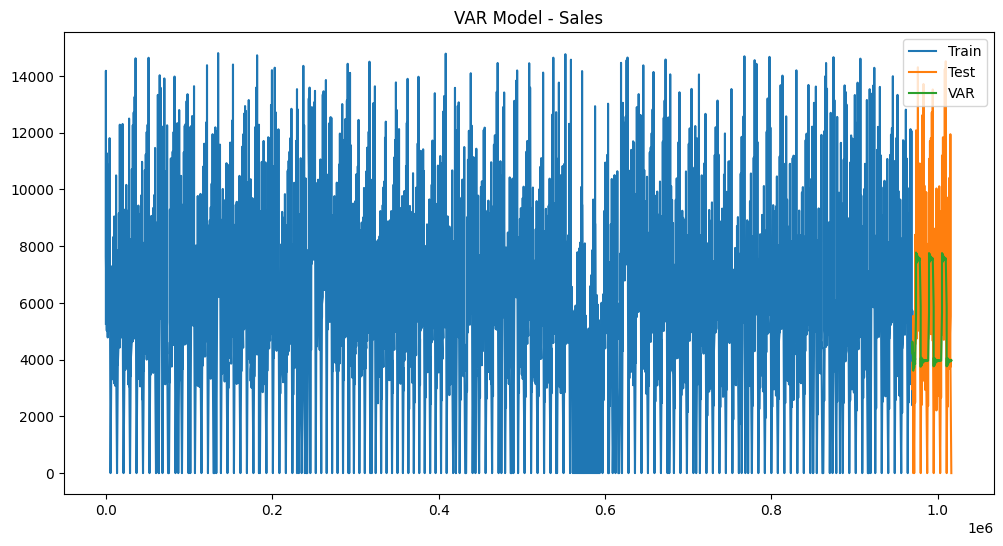

In [143]:
plt.figure(figsize=(12,6))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Sales')
plt.show()

In [144]:
rmse = np.sqrt(mean_squared_error(test.Sales, predictions.Sales)).round(2)

model_comparison=pd.DataFrame()
model_comparison.loc[0,'Model']='VARMAX'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'RMSE']=rmse

# Mean Absolute Percentage Error
abs_error = np.abs(test.Sales-predictions.Sales)
actual = test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)

model_comparison.loc[model_comparison['Variable']=='Sales', 'MAPE'] = mape

# Initialize results_display as an empty DataFrame if it doesn't exist
results_display = pd.DataFrame()
results_display = pd.concat([results_display, model_comparison])
results_display

,Model,Variable,RMSE,MAPE
0,VARMAX,Sales,2653.52,inf
